In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

pd.set_option('display.float_format', '{:.2f}'.format)

# Marvel & LobsterLand Partnership Case Analysis

## Forecasting Disney Total Revenue

In [2]:
## Using DIS quarterly revenue dataset
DIS_Quarter_Earning = pd.read_csv('/Users/leon/My Drive/BU ABA/AD654/Final Project/DIS earning.csv').T
DIS_Quarter_Earning.columns = DIS_Quarter_Earning.iloc[0]
DIS_Quarter_Earning = DIS_Quarter_Earning.iloc[2:33,0:1]
DIS = DIS_Quarter_Earning.iloc[::-1].copy()
DIS.index = pd.to_datetime(DIS.index)
DIS['TotalRevenue'] = DIS['TotalRevenue'].str.replace(',','').astype(float)/1000000000
DIS = DIS.asfreq('Q')
DIS.tail()

name,TotalRevenue
2022-09-30,20.15
2022-12-31,23.51
2023-03-31,21.82
2023-06-30,22.33
2023-09-30,21.24


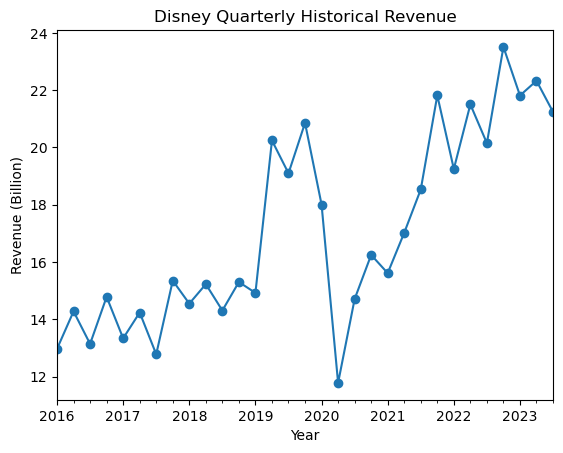

In [3]:
# Plot of the DIS quarterly historical revenue
DIS['TotalRevenue'].plot(title = 'Disney Quarterly Historical Revenue',y = 'TotalRevenue',marker='o')
plt.xlabel('Year') 
plt.ylabel('Revenue (Billion)') 
plt.show()

Disney’s quarterly revenue from 2016 to 2023  (sources: Yahoo Finance) shows a clear trend and seasonality, proved by the decompose method.

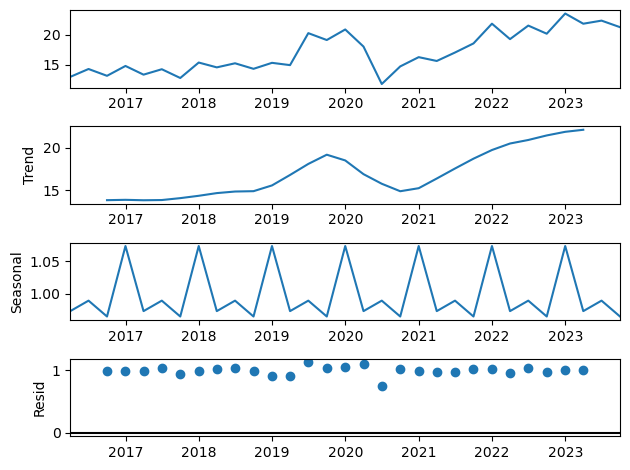

In [4]:
# decompose plot using multiplicative method to check trend and seasonality
decomposition = sm.tsa.seasonal_decompose(DIS, model='multiplicative')

# Plot
fig = decomposition.plot()
plt.show()

Since the data shows trend and seasonality, the Holt-Winters Method is the most suitable method for exponential smoothing.

In [5]:
# Evaluate the accuracy of Holt-Winters’ Seasonal Model.
train_data = DIS.loc['2016-03-31':'2021-12-31']
test_data = DIS.loc['2022-03-31':'2023-09-30']


model = ExponentialSmoothing(
    DIS['TotalRevenue'],
    seasonal_periods=4,  # Quarterly data implies 4 periods per year
    trend='add',
    seasonal='add',
    use_boxcox=True,  # Optional: transform the data to stabilize variance
    initialization_method="estimated"
).fit()

forecast = model.forecast(len(test_data))

mae = mean_absolute_error(test_data['TotalRevenue'], forecast)
mse = mean_squared_error(test_data['TotalRevenue'], forecast)
rmse = mse**0.5

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 3.1982609159743274
MSE: 13.895717022710468
RMSE: 3.7276959402170218


## Random Forest for revenue only

In [6]:
# Convert 'Quarter' to datetime and extract year and quarter
DIS['Year'] = DIS.index.year
DIS['Qtr'] = DIS.index.quarter

# For Random Forest, we'll include Quarter as a feature to capture seasonality
# Since we can't use future data to predict past, we'll exclude 2023 data for training
train_data_rf = DIS[DIS['Year'] < 2023]
test_data_rf = DIS[DIS['Year'] >= 2023]

# Features and target variable
features_rf = ['Year', 'Qtr']
target_rf = 'TotalRevenue'

X_train_rf = train_data_rf[features_rf]
y_train_rf = train_data_rf[target_rf]
X_test_rf = test_data_rf[features_rf]
y_test_rf = test_data_rf[target_rf]

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=0)
# Train the model
rf_model.fit(X_train_rf, y_train_rf)

# Predictions
y_pred_rf = rf_model.predict(X_test_rf)

# Evaluate the model
mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
mse_rf = mean_squared_error(y_test_rf, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

# Prepare the model evaluation metrics
rf_model_evaluation = {
    "MAE": mae_rf,
    "MSE": mse_rf,
    "RMSE": rmse_rf
}
print(rf_model_evaluation)

{'MAE': 1.6109333333333329, 'MSE': 2.9575981642666753, 'RMSE': 1.719766892420794}


## Random Forest with GDP

In [7]:
# Consifering other factors that might affect the revenue --> GDP
# Preparing data
Indicator = pd.read_csv('/Users/leon/My Drive/BU ABA/AD654/Final Project/Indicator.csv')
Indicator.index = DIS.index.copy()
DIS_w_indicator = DIS.copy()
DIS_w_indicator['GDP'] = Indicator.loc[:, 'GDP']
DIS_w_indicator['GDP'] = DIS_w_indicator['GDP'].astype(float)
DIS_w_indicator.head()

name,TotalRevenue,Year,Qtr,GDP
2016-03-31,12.97,2016,1,18525.93
2016-06-30,14.28,2016,2,18711.70
2016-09-30,13.14,2016,3,18892.64
2016-12-31,14.78,2016,4,19089.38
2017-03-31,13.34,2017,1,19280.08


In [8]:
# Convert 'Quarter' to datetime and extract year and quarter
DIS_w_indicator['Year'] = DIS_w_indicator.index.year
DIS_w_indicator['Qtr'] = DIS_w_indicator.index.quarter

# exclude 2023 data for training
train_data_rf = DIS_w_indicator[DIS_w_indicator['Year'] < 2023]
test_data_rf = DIS_w_indicator[DIS_w_indicator['Year'] >= 2023]

# Features and target variable
features_rf = ['GDP', 'Year', 'Qtr']
target_rf = 'TotalRevenue'

X_train_rf = train_data_rf[features_rf]
y_train_rf = train_data_rf[target_rf]
X_test_rf = test_data_rf[features_rf]
y_test_rf = test_data_rf[target_rf]
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(X_train_rf,y_train_rf)
# Predictions
y_pred_rf = rf_model.predict(X_test_rf)

# Evaluate the model
mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
mse_rf = mean_squared_error(y_test_rf, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

# Prepare the model evaluation metrics
rf_model_evaluation = {
    "MAE": mae_rf,
    "MSE": mse_rf,
    "RMSE": rmse_rf
}
print(rf_model_evaluation)

{'MAE': 0.7820733333333353, 'MSE': 0.7785180325999973, 'RMSE': 0.88233668891189}


Since the RMSE of the Random Forest Model with GDP is lower than other model, we will use this model to predict the revenue of 2023 Q4 -- 22.56 billion. In conclusion, the total revenue in 2023 is 87.95 billion dollars.

In [9]:
# Prediction for the 2023 Q4
prediction_data_2023_q4 = pd.DataFrame({
    'GDP': [X_test_rf['GDP'].iloc[-1]],
    'Year': [2023],
    'Qtr': [4]
})

revenue_2023_q4_pred_rf_corrected = round(rf_model.predict(prediction_data_2023_q4)[0],2)
revenue_2023 = y_test_rf.sum() + rf_model.predict(prediction_data_2023_q4)[0]
print(f'The estimated revenue for 2023 Q4 is: ${revenue_2023_q4_pred_rf_corrected}')
print(f'The estimated revenue for whole 2023 is: ${round(revenue_2023,2)}')

The estimated revenue for 2023 Q4 is: $22.56
The estimated revenue for whole 2023 is: $87.95


In [10]:
# Adding the prediction data back to original dataset
DIS_final_est = DIS_w_indicator.copy()
new_row = pd.DataFrame({
    'Year': [2023],
    'Qtr': [4],
    'GDP': [X_test_rf['GDP'].iloc[-1]],
    'TotalRevenue': [revenue_2023_q4_pred_rf_corrected]
})
DIS_final_est = DIS_final_est.append(new_row)
# Convert the index to a list
index_list = DIS_final_est.index.tolist()

# Change the last element of the index list to the new date
index_list[-1] = '2023-12-31'

# Update the DataFrame's index
DIS_final_est.index = index_list

# Convert the index to a datetime object if it isn't already
DIS_final_est.index = pd.to_datetime(DIS_final_est.index)

/var/folders/gn/9mm5s2ks2t5_qlwl1wbn4vp40000gn/T/ipykernel_88377/2289841446.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DIS_final_est = DIS_final_est.append(new_row)


## Visualizing GDP and Revenue after the prediction

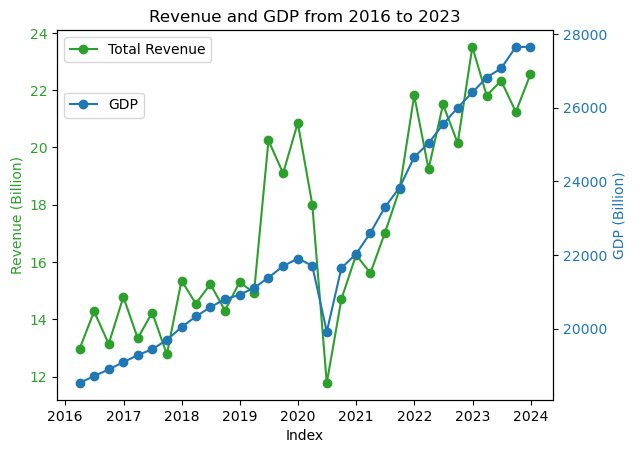

In [11]:
# Create the figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first column
color1 = 'tab:green'
ax1.plot(DIS_final_est.index, DIS_final_est['TotalRevenue'], color=color1, label='Total Revenue',marker='o')
ax1.set_xlabel('Index')
ax1.set_ylabel('Revenue (Billion)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Create the second axis
ax2 = ax1.twinx()

# Plot the second column
color2 = 'tab:blue'
ax2.plot(DIS_final_est.index, DIS_final_est['GDP'], color=color2, label='GDP',marker='o')
ax2.set_ylabel('GDP (Billion)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Optionally add legends
ax1.legend(loc='upper left',bbox_to_anchor=(0, 1))
ax2.legend(loc='upper left',bbox_to_anchor=(0, 0.85))

# Show the plot
plt.title('Revenue and GDP from 2016 to 2023')
plt.show()

# Predicting A Family’s Preference For Indoor Or Outdoor Activities

To predict whether a particular household’s primary goal for attending a winter carnival will be ‘indoor’ or ‘outdoor’, two methods came into our mind: Logistic Regression and Random Model. But before deciding which method to use, firstly we would like to explore the dataset.

In [12]:
carnival =pd.read_csv('/Users/leon/My Drive/BU ABA/AD654/Final Project/carnival-visitors.csv')
carnival.head()

,visitorID,age,gender,prev_wincarn,homestate,phys_level,travel_dist,occupation,companion_type,ski_snowboard,social_media,preference
0,1391,23,Male,2,Quebec,Sedentary,13.75,student,fam_children,1,0.47,Indoor
1,1463,31,Male,0,Quebec,Sedentary,6.78,blue collar,fam_children,1,0.73,Outdoor
2,1859,39,Male,1,Quebec,Sedentary,3.47,white collar,fam_children,1,0.98,Outdoor
3,1523,24,Male,3,Quebec,Sedentary,16.87,student,solo,1,0.30,Outdoor
4,100,45,Male,2,Quebec,Sedentary,13.08,white collar,friends,1,0.34,Outdoor


In [13]:
numeric_variable = ['age','travel_dist','social_media']
categorical_variable = ['gender','prev_wincarn','homestate','phys_level','occupation','companion_type','ski_snowboard']
target = ['preference']

Firstly we analyze the distribution of ‘preference’ in each categorical variable – making sure they are capable of showing differences to further use in the prediction model. The result is in the below chart – seems like every categorical variable can be used, yet ‘prev_wincarn’ and ‘homestate’ show more unique values.

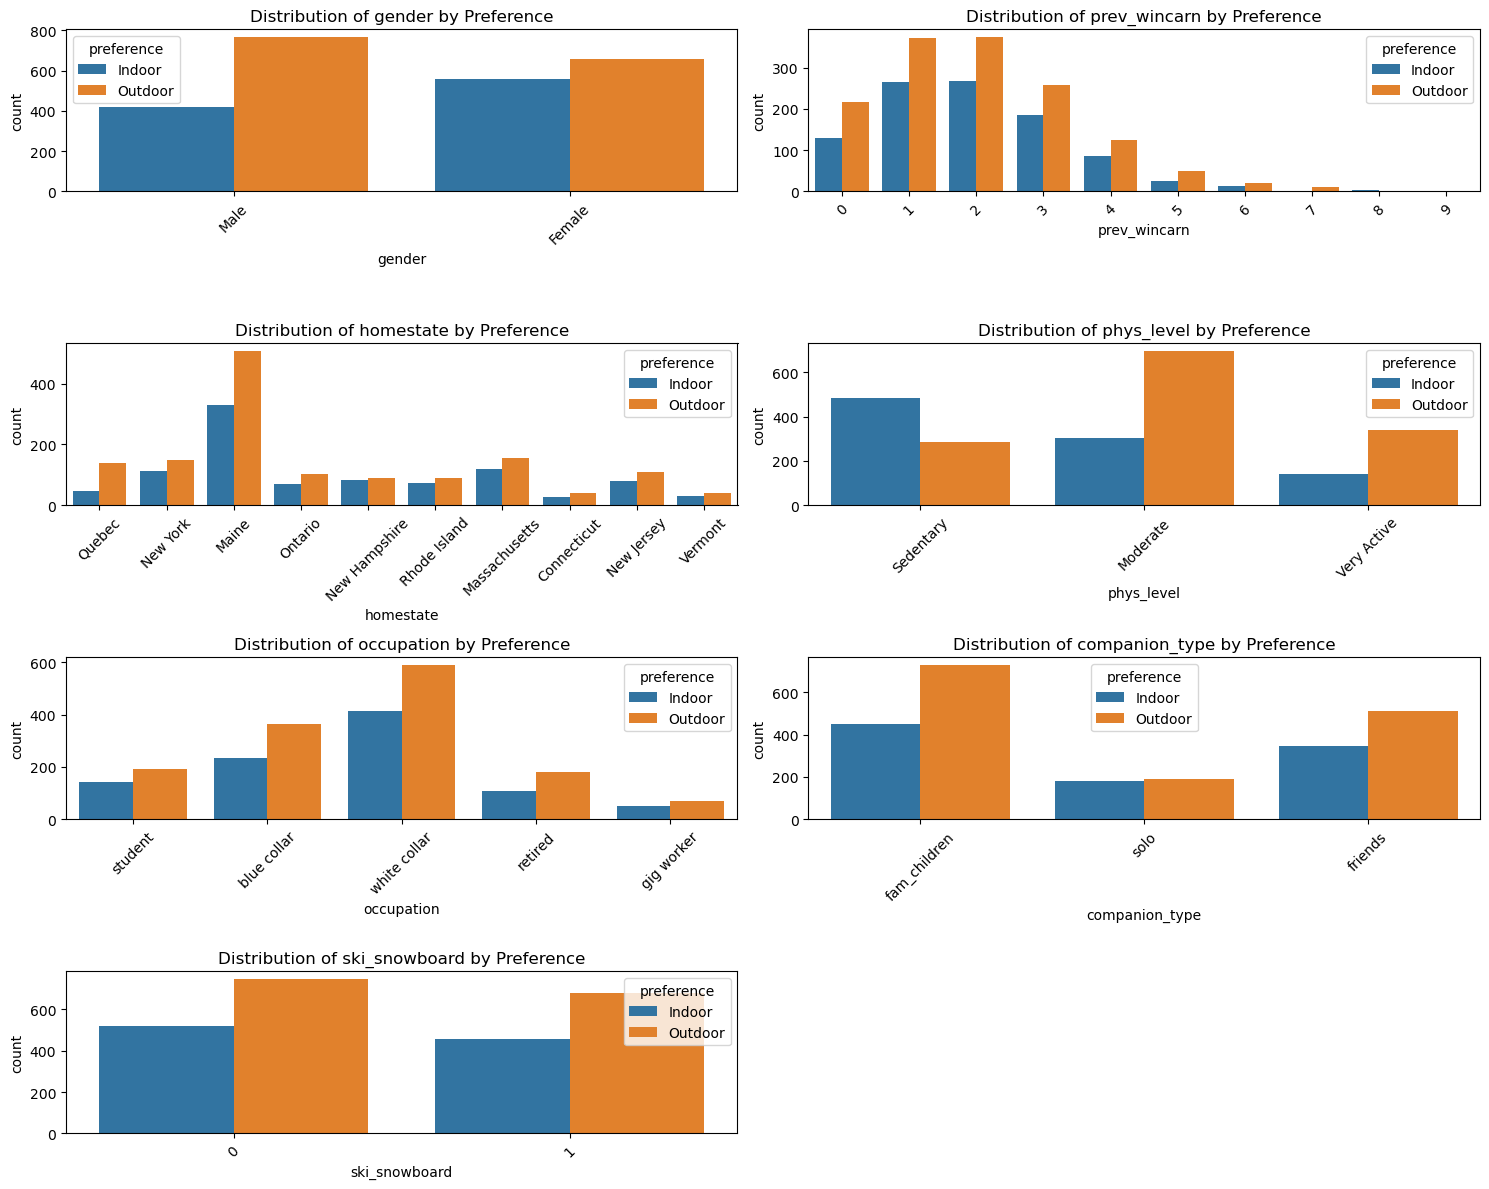

In [14]:
# Analyzing the distribution of categorical variables with respect to the 'preference' target variable
plt.figure(figsize=(15, 12))

for i, var in enumerate(categorical_variable):
    plt.subplot(4, 2, i + 1)
    sns.countplot(x=var, hue='preference', data=carnival)
    plt.title(f'Distribution of {var} by Preference')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Since we believe that future visitors will come from other states not mentioned in the original dataset, we transferred the ‘homestate’ variable to:
- 1 → in the US
- 0 → outside of US

Also we transfer the ‘prev_wincarn’ variable to less category by:

- highly_interested → visited more than 3 times
- Interested → visited between 1 to 3 times
- not_interested → did not visit before.

In [15]:
# Modify homestate and prev_wincarn variable
not_us = ['Quebec','Ontario']
carnival['homestate'] = carnival['homestate'].apply(lambda x: '0' if x in not_us else '1')
carnival['prev_wincarn'] = carnival['prev_wincarn'].apply(lambda x: 'not_interested' if x == 0 else ('interested' if 1 <= x <= 3 else 'highly_interested'))

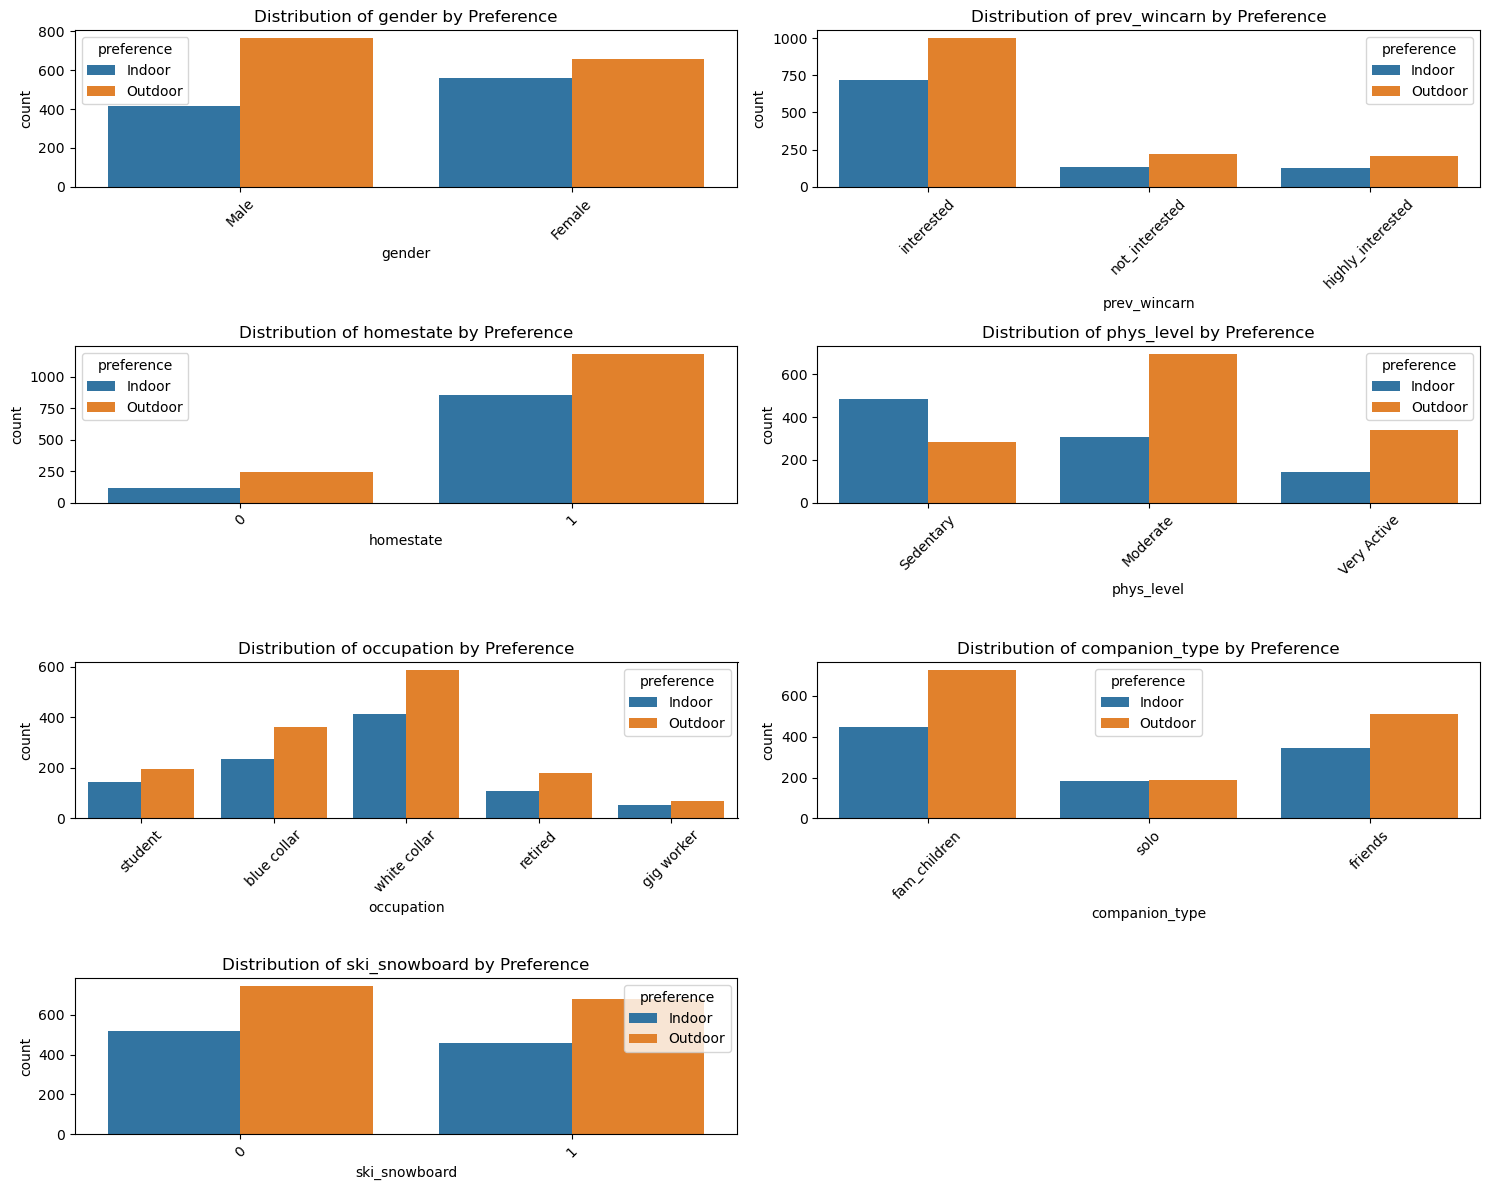

In [16]:
plt.figure(figsize=(15, 12))

for i, var in enumerate(categorical_variable):
    plt.subplot(4, 2, i + 1)
    sns.countplot(x=var, hue='preference', data=carnival)
    plt.title(f'Distribution of {var} by Preference')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Building a Logistic Regression Model

In [17]:
# Dummy variable
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_variable),
        ('cat', OneHotEncoder(drop='first'), categorical_variable)
    ])

# Split data to train and test
X = carnival.drop('preference', axis=1)
y = carnival['preference']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=654)


pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor_lr),
                              ('classifier', LogisticRegression(max_iter=1000, random_state=654))])
pipeline_lr.fit(X_train, y_train)

# Prediction
y_pred_lr = pipeline_lr.predict(X_test)

# Calculating accuracy and AUC for Logistic Regression model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, pipeline_lr.predict_proba(X_test)[:, 1])

# Extracting feature names after one-hot encoding
feature_names_lr = (pipeline_lr.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(input_features=categorical_variable))

# Combining feature names for both numeric and categorical variables
feature_names_lr = np.concatenate([numeric_variable, feature_names_lr])
# Getting coefficients for Logistic Regression model
coefficients_lr = pipeline_lr.named_steps['classifier'].coef_[0]

# Creating a DataFrame for Logistic Regression feature importance
lr_feature_importance = pd.DataFrame({'Feature': feature_names_lr, 'Coefficient': coefficients_lr})
lr_top_features = lr_feature_importance.reindex(lr_feature_importance.Coefficient.abs().sort_values(ascending=False).index).head(4)

print(f'The accuracy of Logistic Regression Model is: {round(accuracy_lr,2)} with AUC = {round(auc_lr,2)}')
lr_feature_importance
lr_top_features

The accuracy of Logistic Regression Model is: 0.68 with AUC = 0.71


,Feature,Coefficient
7,phys_level_Sedentary,-1.37
16,companion_type_solo,-0.57
6,homestate_1,-0.49
3,gender_Male,0.43


## Random Forest Model

In [18]:
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_variable),
        ('cat', OneHotEncoder(), categorical_variable)
    ])
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor_rf),
                              ('classifier', RandomForestClassifier(random_state=654))])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

# Calculating accuracy and AUC for Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, pipeline_rf.predict_proba(X_test)[:, 1])

# Getting feature importances for Random Forest model
feature_importances_rf = pipeline_rf.named_steps['classifier'].feature_importances_

# Extracting feature names for Random Forest model (no level dropped)
feature_names_rf = (pipeline_rf.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(input_features=categorical_variable))

# Combining feature names for both numeric and categorical variables
feature_names_rf = np.concatenate([numeric_variable, feature_names_rf])

# Creating a DataFrame for Random Forest feature importance
rf_feature_importance = pd.DataFrame({'Feature': feature_names_rf, 'Importance': feature_importances_rf})
rf_top_features = rf_feature_importance.reindex(rf_feature_importance.Importance.abs().sort_values(ascending=False).index).head(4)


print(f'The accuracy of Random Forest Model is: {round(accuracy_rf,2)} with AUC = {round(auc_rf,2)}')
rf_feature_importance
rf_top_features

The accuracy of Random Forest Model is: 0.65 with AUC = 0.69


,Feature,Importance
1,travel_dist,0.20
2,social_media,0.19
0,age,0.18
11,phys_level_Sedentary,0.07


# Ice Scukture Selection A/B Testing

To determine the most effective picture for the marketing campaign, we firstly compare the average spend and register rates for each picture.

In [19]:
ice =pd.read_csv('/Users/leon/My Drive/BU ABA/AD654/Final Project/ice_sculptures.csv')

In [20]:
# Grouping data by 'pic_seen' and calculating mean spend and registration rate
grouped_data = ice.groupby('pic_seen').agg({'spend': 'mean', 'register': 'mean'}).reset_index()
grouped_data

,pic_seen,spend,register
0,Captain America,18.61,0.35
1,Ironman,16.78,0.44
2,Spiderman,14.02,0.34


'Captain America' achieved the highest spend, and 'Ironman' achieve the highest register rate. Before making this conclusion, we use statistical testing to check if there is actually differences in the average spend and register rate.

For testing the spending, we use ANOVA since dependent variable (spend) is a continuous variable, and the independent variable (picture) has more than two levels.

For testing the register rate, we use Chi-squared Test both the dependent (register) and independent (picture) are both categorical variable.

In [21]:
# Conducting ANOVA test for 'spend' across different pictures
anova_result_spend = stats.f_oneway(
    ice[ice['pic_seen'] == 'Ironman']['spend'],
    ice[ice['pic_seen'] == 'Spiderman']['spend'],
    ice[ice['pic_seen'] == 'Captain America']['spend']
)

# Preparing data for Chi-squared test for 'register'
contingency_table = pd.crosstab(ice['pic_seen'], ice['register'])

# Conducting Chi-squared test for 'register'
chi2_result_register, p_register, _, _ = stats.chi2_contingency(contingency_table)

print(f'p-value of ANOVA testing is: {anova_result_spend[1]}') 

print(f'p-value of Chi-squared test is: {(chi2_result_register, p_register)[1]}')


p-value of ANOVA testing is: 0.0
p-value of Chi-squared test is: 4.52952647949813e-07


In both statistical testing, the p-value are lower than significance value, meaning we reject the null hypothesis and conclude that there is differences in 'spend' and 'register' for each picture.

In conclusion, the most effective picture for marketing campaign will decided by the business goal:
- Maximize revenue --> Captain America
- Maximize Registration --> Iron Man